## Problem formulation

$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\P}{\mathbb{P}}$
### Problem
For $i \in \{0, \ldots N -1\}$ consider independent 
$$Y_i \sim Norm(0,1) \tag{i}\label{i}$$
$$ Z^{(0)}_i,Z^{(1)}_i \sim Norm(Y_i, \sigma^2) \tag{ii}$$
We measure all $Z$, we want to estimate $\sigma^2$ and we don't care about the values of $Y$.

### Frequentist simple maximal likelihood estimator
In the simplistic frequentist approach we do not even need ($\ref{i}$). We consider $M_i, \sigma^2$ as unknown parameters and look for them by maximalizing the likelihood. We get 
$$\hat\sigma_{mle}^2 = \frac{1}{4} \sum_i \frac{(X_i - Y_i)^2}{N} \to \frac 1 2 \sigma^2.$$
so it is not very satisfactory.

### Bayesian approach
For a Bayesian approach we must furthermore specify a prior on $\sigma^2$. It is easier for us to work with $\log(\sigma^2)\in \R$ rather than $\sigma^2 \in \R_{+}$ and we choose inproper
$$\P\big[\log(\sigma^2) \in dx\big] \propto dx \tag{iii}$$

**Remark:** The prior does not save us from the above problem. If we maximize the joint posterior on $\sigma^2, M$, we get basically the same result. 

## Imports and setup

In [1]:
import numpy as np

import matplotlib.pyplot as pl
%matplotlib inline

In [2]:
import tensorflow as tf
import tensorflow.distributions as tfd
from tensorflow.distributions import Normal, Bernoulli
from tensorflow.nn import softmax
from tensorflow import exp, log, ones, zeros

tf.enable_eager_execution()

In [3]:
from typing import Callable

In [4]:
## changing the width of cells
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

In [5]:
floatX = np.float32

## Bayesian model
God generates "forces" $Y_i\sim Norm(\mu, \lambda^2)$ for $i\in\{0, \ldots N-1\}$.
Afterwards, Nature generates observations $Z^{(0)}_i,Z^{(1)}_i \sim Norm(Y_i, \sigma^2)$. 

### Generate artificial data

In [6]:
μ_true = 0.
λ_true = 3.
σ_true = 2.
N = 100

Y_true = Normal(μ_true, λ_true).sample(N)
Z_obs = Normal(loc=Y_true, scale=σ_true).sample(2)
Z_obs = tf.transpose(Z_obs)

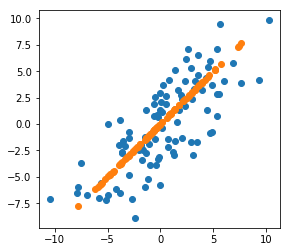

In [7]:
## plot input data
fig, ax = pl.subplots()
ax.set_aspect("equal")
pl.scatter(*Z_obs.numpy().T)
pl.scatter(Y_true.numpy(), Y_true.numpy())

### Change of variables
We have constraints $\lambda, \sigma >0$. To get rid of them we introduce
$$\beta = \log\lambda^2,\,\gamma=\log\sigma^2 \quad\text{i.e.}\quad \lambda = e^{\beta/2}, \sigma = e^{\gamma/2}.$$
We take our model paramters to be $\theta := (\mu, \beta, \gamma)$

In [8]:
def get_μλσ(θ):
    μ, β, γ = θ
    λ = exp(β/2)
    σ = exp(γ/2)
    return μ, λ, σ

### Given distributions
$\newcommand{P}{\mathbb{P}}$
$\newcommand{R}{\mathbb{R}}$
$\newcommand{Z}{\mathbb{Z}}$
$\newcommand{E}{\mathbb{E}}$
#### $\P(\theta)$ - prior on model parameters

In [9]:
μ_prior = Normal(loc=0., scale=1.)
β_prior = Normal(loc=0., scale=1.)
γ_prior = Normal(loc=0., scale=1.)

def θ_log_prior(θ) -> "scalar":
    μ, β, γ = θ
    return μ_prior.log_prob(μ) + β_prior.log_prob(β) + γ_prior.log_prob(γ)

In [10]:
## test
θ_log_prior((0., 0., 0.))

<tf.Tensor: id=83, shape=(), dtype=float32, numpy=-2.7568154>

#### $\P(Y_i\mid \theta)$ - "prior" on latent variables

In [11]:
def Y_log_priors(Y, θ):
    μ, λ, σ = get_μλσ(θ)
    return Normal(μ, λ).log_prob(Y)

In [12]:
## test
Y_log_priors(Y_true, (0.,0.,0.)).shape

TensorShape([Dimension(100)])

#### $\P(Z_i\mid Y_i,\ \theta)$ - "likelihood"

In [13]:
def Z_log_probas(Z, Y, θ):
    """
    Args:
        Z: tensor of shape `[N, 2]`
        Y: tensor of shape `[N]`
        θ: tuple of model parameters
    Returns:
        tensor of shape `[N]`
    """
    μ, λ, σ = get_μλσ(θ)
    return tf.reduce_sum(
        Normal(loc=Y[:, None], scale=σ).log_prob(Z),
        axis = -1
    )

In [14]:
## test
Z_log_probas(Z_obs, Y_true, (0.,0.,0.)).shape

TensorShape([Dimension(100)])

### EM-algorithm

#### Variables

In [15]:
n_reps = 1
Z = tf.tile(Z_obs, [n_reps, 1])
Z.shape

TensorShape([Dimension(100), Dimension(2)])

In [16]:
Y = tf.Variable(zeros(Z.shape[0]))

In [17]:
θ = (
    tf.Variable(0., name = "mu"),
    tf.Variable(0., name = "beta"),
    tf.Variable(0., name = "gamma"),
)

In [18]:
μ, β, γ = θ

#### E-step --- MCMC
* Do several independent MCMC updates of all $y_i$ with the unnormalized densities $y_i\mapsto  \P(y_i\mid \theta) \cdot \P(z_i\mid \theta, y_i)$

Denote `losses[i]:=` $-\log\P(y_i\mid \theta) -\log \P(z_i\mid \theta, y_i)$

In [19]:
def get_losses(Z, Y, θ) -> "Tensor of shape [N]":
    return - Y_log_priors(Y, θ) - Z_log_probas(Z, Y, θ)

In [20]:
def MetropolisHastings_update(
    x: tf.Variable, get_losses: Callable, step_size:float, n_steps:int=1
) -> None:
    """Update values in `x` using several steps of Metropolis-Hastings algorithm.
    
    We want to sample a batch of independent random variables $x_i$ given by batch of 
    unnormalized densities $f_i(x_i)$. These $f(i)$ are specified by
    `get_losses(x)[i]` = $-log(f_i(x_i))$.
    """

    loss_current = get_losses(x)
    for i in range(n_steps):
        x_suggest = Normal(loc=x, scale=step_size).sample()
        loss_suggest = get_losses(x_suggest)

        proba_of_step = tf.minimum(exp(loss_current - loss_suggest), 1)
        step_or_not = Bernoulli(probs=proba_of_step, dtype = tf.bool).sample()

        x.assign(tf.where(step_or_not, x_suggest, x));
        loss_current = tf.where(step_or_not, loss_suggest, loss_current)

In [21]:
## Test
def test_MetropolisHastings_update():
    """Use Metropolis-Hastings to sample from  Normal(0, 1)."""
    x = tf.Variable(zeros(100))
    MetropolisHastings_update(
        x, get_losses = lambda x: - Normal(0., 1.).log_prob(x), 
        step_size=.1, n_steps=1000)
    mean, var = tf.nn.moments(x, axes=0)
    assert abs(mean) < 0.3 and abs(var - 1) < 0.3

test_MetropolisHastings_update()

In [22]:
def E_step(step_size=0.1, n_steps=100) -> None: 
    MetropolisHastings_update(
        get_losses = lambda x: get_losses(Z=Z, Y=x, θ=θ),
        x = Y,
        step_size = step_size,
        n_steps = n_steps
    )

#### M-step --- gradient descent on $\theta$

with fixed $y$ make several gradient-descent steps in $\theta$ as if trying to maximize the function of $\theta$
$$\theta \mapsto \log\big(\P(\theta) \cdot\P(y\mid \theta) \cdot \P(z\mid \theta, y)\big)$$
Denote `loss:=` $-\log\P(\theta) - \sum_i\log\P(y_i\mid \theta)  - \sum_i\log\P(z_i\mid \theta, y_i)$

In [23]:
def get_loss(Z, Y, θ) -> "scalar":
    return θ_log_prior(θ) - tf.reduce_sum(Y_log_priors(Y, θ)) - tf.reduce_sum(Z_log_probas(Z, Y, θ))

In [24]:
optimizer = tf.train.AdamOptimizer()

In [25]:
def M_step(n_steps:int = 100) -> None:
    for i in range(n_steps):
        with tf.GradientTape() as tape:
            loss = get_loss(Z, Y, θ)

        grad = tape.gradient(loss, θ)
        optimizer.apply_gradients(zip(grad, θ))
   
M_step()

#### Run EM-algorithm

In [31]:
for i in range(1000):
    E_step(step_size=1., n_steps=10)
    M_step(n_steps=10)

In [32]:
get_μλσ(θ)

(<tf.Variable 'mu:0' shape=() dtype=float32, numpy=0.08547374>,
 <tf.Tensor: id=11147276, shape=(), dtype=float32, numpy=3.6910186>,
 <tf.Tensor: id=11147279, shape=(), dtype=float32, numpy=1.928212>)

In [28]:
μ_true, λ_true, σ_true

(0.0, 3.0, 2.0)

# Bordel

In [25]:
def M_step_only_gamma(n_steps:int = 100) -> None:
    for i in range(n_steps):
        with tf.GradientTape() as tape:
            loss = get_loss(Z, Y, θ)

        grad = tape.gradient(loss, γ)
        optimizer.apply_gradients([(grad, γ)])
   
M_step_only_gamma()

In [75]:
μ.assign(μ_true)
β.assign(log(λ_true**2))

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=4.6051702>

In [84]:
for i in range(100000):
    E_step(step_size=0.01, n_steps=10)
    M_step_only_gamma(n_steps=10)